<a href="https://colab.research.google.com/github/MattRamb97/Erasmus_Hardgainers/blob/main/Recipes_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**RECIPES MODEL**

We utilized the URLs provided to access the datasets stored in the folder https://raw.githubusercontent.com/MattRamb97/Erasmus_Hardgainers/main/Datasets/

using the pandas library. Subsequently, we identified an issue in the 'ingredients' column of the three datasets, characterized by the presence of the word 'ADVERTISEMENT', which we proceeded to remove. Additionally, we printed information regarding one of the datasets (the same information applies to the others) and their respective shapes.

In [ ]:
url_1 = 'https://raw.githubusercontent.com/MattRamb97/Erasmus_Hardgainers/main/Datasets/recipes_raw_nosource_ar.json'
url_2 = 'https://raw.githubusercontent.com/MattRamb97/Erasmus_Hardgainers/main/Datasets/recipes_raw_nosource_epi.json'
url_3 = 'https://raw.githubusercontent.com/MattRamb97/Erasmus_Hardgainers/main/Datasets/recipes_raw_nosource_fn.json'

import pandas as pd
df_ar = pd.read_json(url_1, orient='records', dtype='dict').transpose()
df_ar.info()
print()
df_epi = pd.read_json(url_2, orient='records', dtype='dict').transpose()
df_fn = pd.read_json(url_3, orient='records', dtype='dict').transpose()

df_ar['title'] = df_ar['title'].astype(str)
df_epi['title'] = df_epi['title'].astype(str)
df_fn['title'] = df_fn['title'].astype(str)

# Remove the word 'ADVERTISEMENT' from each text entry in the 'ingridients'
df_ar['ingredients'] = df_ar['ingredients'].astype(str).str.replace('ADVERTISEMENT', '',regex=True)
df_epi['ingredients'] = df_epi['ingredients'].astype(str).str.replace('ADVERTISEMENT', '',regex=True)
df_fn['ingredients'] = df_fn['ingredients'].astype(str).str.replace('ADVERTISEMENT', '',regex=True)

df_ar['instructions'] = df_ar['instructions'].astype(str)
df_epi['instructions'] = df_epi['instructions'].astype(str)
df_fn['instructions'] = df_fn['instructions'].astype(str)

print('From AR:', df_ar.shape)
print('From EPI: ', df_epi.shape)
print('FROM FN:', df_fn.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 39802 entries, rmK12Uau.ntP510KeImX506H6Mr6jTu to 2Q3Zpfgt/PUwn1YABjJ5A9T3ZW8xwVa
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         39522 non-null  object
 1   ingredients   39522 non-null  object
 2   instructions  39522 non-null  object
 3   picture_link  39522 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB

From AR: (39802, 4)
From EPI:  (25323, 4)
FROM FN: (60039, 4)


We cleaned the three datasets using two function:
- uncontract(): expands contracted words commonly found in English sentences into their full forms using regular expressions.
- clean_recepies(): removes non-alphanumeric characters from the input text except for spaces and hyphens. It then replaces multiple spaces and hyphens with a single space and normalizes units of measurement (e.g., cups, tablespoons) by removing them. Next, it removes numerical digits, assuming they represent quantities. Finally, it normalizes whitespace by removing extra spaces and ensuring consistent spacing between words.

In [ ]:
from tqdm.auto import tqdm
import re

# Basic cleaning apply before the tokenization
def uncontract(text):
    text = re.sub(r"(\b)([Aa]re|[Cc]ould|[Dd]id|[Dd]oes|[Dd]o|[Hh]ad|[Hh]as|[Hh]ave|[Ii]s|[Mm]ight|[Mm]ust|[Ss]hould|[Ww]ere|[Ww]ould)n't", r"\1\2 not", text)
    text = re.sub(r"(\b)([Hh]e|[Ii]|[Ss]he|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'ll", r"\1\2 will", text)
    text = re.sub(r"(\b)([Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'re", r"\1\2 are", text)
    text = re.sub(r"(\b)([Ii]|[Ss]hould|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Ww]ould|[Yy]ou)'ve", r"\1\2 have", text)

    text = re.sub(r"(\b)([Cc]a)n't", r"\1\2n not", text)
    text = re.sub(r"(\b)([Ii])'m", r"\1\2 am", text)
    text = re.sub(r"(\b)([Ll]et)'s", r"\1\2 us", text)
    text = re.sub(r"(\b)([Tt]here)'s", r"\1\2 is", text)
    text = re.sub(r"(\b)([Ww])on't", r"\1\2ill not", text)
    text = re.sub(r"(\b)([Ss])han't", r"\1\2hall not", text)
    text = re.sub(r"(\b)([Yy])(?:'all|a'll)", r"\1\2ou all", text)

    return text

# Specific cleaning for every single tweet
def clean_recepies(text):
     # Remove non-alphanumeric characters except spaces and hyphens
    text = re.sub(r'[^\w\s-]', '', text)

    # Replace multiple spaces and hyphens with a single space
    text = re.sub(r'[-\s]+', ' ', text)

    # Normalize units of measurement (e.g., cups, tablespoons)
    text = re.sub(r'\b(tsp|tbsp|cup|oz|ounce|lb|pound|g|gram|kg|kilogram)\b', '', text, flags=re.IGNORECASE)

    # Remove numbers (assuming they represent quantities)
    text = re.sub(r'\b\d+\b', '', text)

    # Normalize whitespace
    text = ' '.join(text.split())

    return text

# Concatenate titles from all datasets
all_titles = pd.concat([df_ar['title'], df_epi['title'], df_fn['title']], ignore_index=True)
all_ingr = pd.concat([df_ar['ingredients'], df_epi['ingredients'], df_fn['ingredients']], ignore_index=True)
all_inst = pd.concat([df_ar['instructions'], df_epi['instructions'], df_fn['instructions']], ignore_index=True)

# Applying the function uncontract() for basic cleaning
all_titles = [uncontract(t) for t in tqdm(all_titles)]
all_ingr = [uncontract(t) for t in tqdm(all_ingr)]
all_inst = [uncontract(t) for t in tqdm(all_inst)]

# Applying the function clean_tweet() for the tweet specific cleaning
all_titles = [clean_recepies(t) for t in tqdm(all_titles)]
all_ingr = [clean_recepies(t) for t in tqdm(all_ingr)]
all_inst = [clean_recepies(t) for t in tqdm(all_inst)]

'''
###################
#       AR        #
###################

# Applying the function uncontract() for basic cleaning to ar
df_ar_title = [uncontract(t) for t in tqdm(df_ar['title'])]
df_ar_ingredients = [uncontract(t) for t in tqdm(df_ar['ingredients'])]
df_ar_instructions = [uncontract(t) for t in tqdm(df_ar['instructions'])]

# Applying the function clean_tweet() for the tweet specific cleaning ar
df_ar_title = [clean_recepies(t) for t in tqdm(df_ar['title'])]
df_ar_ingredients = [clean_recepies(t) for t in tqdm(df_ar['ingredients'])]
df_ar_instructions = [clean_recepies(t) for t in tqdm(df_ar['instructions'])]

###################
#      EPI        #
###################

# Applying the function uncontract() for basic cleaning to ar
df_epi_title = [uncontract(t) for t in tqdm(df_epi['title'])]
df_epi_ingredients = [uncontract(t) for t in tqdm(df_epi['ingredients'])]
df_epi_instructions = [uncontract(t) for t in tqdm(df_epi['instructions'])]

# Applying the function clean_tweet() for the tweet specific cleaning ar
df_epi_title = [clean_recepies(t) for t in tqdm(df_epi['title'])]
df_epi_ingredients = [clean_recepies(t) for t in tqdm(df_epi['ingredients'])]
df_epi_instructions = [clean_recepies(t) for t in tqdm(df_epi['instructions'])]

###################
#       FN        #
###################

# Applying the function uncontract() for basic cleaning to ar
df_fn_title = [uncontract(t) for t in tqdm(df_fn['title'])]
df_fn_ingredients = [uncontract(t) for t in tqdm(df_fn['ingredients'])]
df_fn_instructions = [uncontract(t) for t in tqdm(df_fn['instructions'])]

# Applying the function clean_tweet() for the tweet specific cleaning ar
df_fn_title = [clean_recepies(t) for t in tqdm(df_fn['title'])]
df_fn_ingredients = [clean_recepies(t) for t in tqdm(df_fn['ingredients'])]
df_fn_instructions = [clean_recepies(t) for t in tqdm(df_fn['instructions'])]
'''

  0%|          | 0/125164 [00:00<?, ?it/s]

  0%|          | 0/125164 [00:00<?, ?it/s]

  0%|          | 0/125164 [00:00<?, ?it/s]

  0%|          | 0/125164 [00:00<?, ?it/s]

  0%|          | 0/125164 [00:00<?, ?it/s]

  0%|          | 0/125164 [00:00<?, ?it/s]

"\n###################\n#       AR        #\n###################\n\n# Applying the function uncontract() for basic cleaning to ar\ndf_ar_title = [uncontract(t) for t in tqdm(df_ar['title'])]\ndf_ar_ingredients = [uncontract(t) for t in tqdm(df_ar['ingredients'])]\ndf_ar_instructions = [uncontract(t) for t in tqdm(df_ar['instructions'])]\n\n# Applying the function clean_tweet() for the tweet specific cleaning ar\ndf_ar_title = [clean_recepies(t) for t in tqdm(df_ar['title'])]\ndf_ar_ingredients = [clean_recepies(t) for t in tqdm(df_ar['ingredients'])]\ndf_ar_instructions = [clean_recepies(t) for t in tqdm(df_ar['instructions'])]\n\n###################\n#      EPI        #\n###################\n\n# Applying the function uncontract() for basic cleaning to ar\ndf_epi_title = [uncontract(t) for t in tqdm(df_epi['title'])]\ndf_epi_ingredients = [uncontract(t) for t in tqdm(df_epi['ingredients'])]\ndf_epi_instructions = [uncontract(t) for t in tqdm(df_epi['instructions'])]\n\n# Applying the f

In [3]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

Create a formatting_func to structure training examples as prompts.

In [12]:
def formatting_func(title, ingredients):
    text = f"### Title: {title}\n ### Ingredients: {ingredients}"
    return text
'''
def formatting_func(example):
    text = f"### Title: {example['input']}\n ### Ingredients: {example['output']}"
    return text
'''

'\ndef formatting_func(example):\n    text = f"### Title: {example[\'input\']}\n ### Ingredients: {example[\'output\']}"\n    return text\n'

Load Mistral - mistralai/Mistral-7B-v0.1

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Set up the tokenizer. Add padding on the left as it makes training use less memory. For model_max_length, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [13]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(title, ingredients):
    return tokenizer(formatting_func(title, ingredients))
'''
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))
'''

'\ndef generate_and_tokenize_prompt(prompt):\n    return tokenizer(formatting_func(prompt))\n'

Reformat the prompt and tokenize each sample

In [15]:
tokenized_titles = []
tokenized_ingredients = []

for title, ingredients in zip(df_ar['title'], df_ar['ingredients']):
    tokenized_titles.append(generate_and_tokenize_prompt(title, ingredients))
    tokenized_ingredients.append(generate_and_tokenize_prompt(title, ingredients))

#tokenized_titles = [generate_and_tokenize_prompt(title, ingredients) for title, ingredients in zip(df_ar['title'], df_ar['ingredients'])]

Let's get a distribution of our dataset lengths, so we can determine the appropriate max_length for our input tensors.

79604


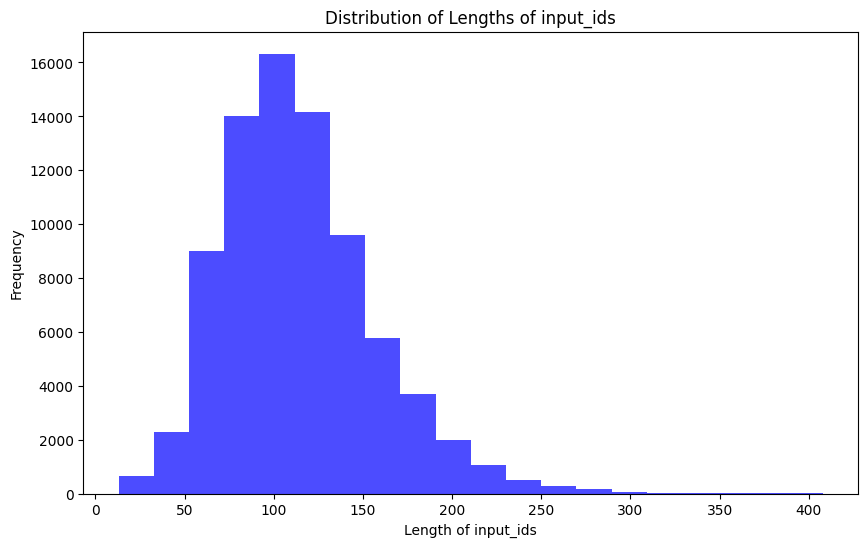

In [16]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_titles, tokenized_ingredients):
    lengths = [len(x['input_ids']) for x in tokenized_titles]
    lengths += [len(x['input_ids']) for x in tokenized_ingredients]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_titles, tokenized_ingredients)